In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [269]:
PATH = "datasets/combined_ai_human_indonesia.csv"
SEED = 42

In [270]:
import random
import tensorflow as tf, torch

In [271]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [272]:
df = pd.read_csv(PATH)

In [273]:
df.head()

,message,label
0,"Perusahaan manufaktur milik keluarga , PT Buka...",0
1,"Federasi Sepak Bola Internasional, FIFA resmi ...",0
2,Silicon Valley Bank (SVB) telah mengibarkan be...,0
3,lebih enak naik pesawat daripada naik sepeda,0
4,Seabria adalah genus kumbang tanduk panjang ya...,0


In [274]:
df.tail()

,message,label
209219,Angkong adalah suatu kendaraan bertenaga manus...,0
209220,anak-anak yang mengikuti dari belakang bisa me...,0
209221,"Yerida ( yerida, ""keturunan"") adalah sebuah is...",0
209222,Olenecamptus nigromaculatus adalah spesies kum...,0
209223,Tipula (Eumicrotipula) pediformis adalah spesi...,0


In [275]:
df.shape

(209224, 2)

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209224 entries, 0 to 209223
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   message  208725 non-null  object
 1   label    209224 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


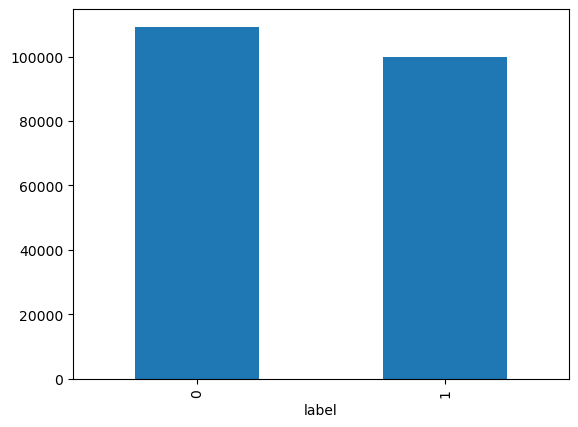

In [277]:
df["label"].value_counts().plot(kind="bar")
plt.show()

In [278]:
import re

In [279]:
def text_preprocessing(text):
  # Cleaning
  text = text.replace('-', ' ')
  text = re.sub(r'[\r\xa0\t]', '', text)
  text = re.sub(r"http\S+|www\S+", '', text)
  text = re.sub(r'\b\w*\.com\w*\b', '', text)
  text = re.sub(r'\[.*?\]|\(.*?\}|\{.*?\}', '', text)
  text = re.sub(r'\b(\w+)/(\w+)\b', r'\1 atau \2', text)
  text = re.sub(r'@[A-Za-z0-9]+|#[A-Za-z0-9]+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  text = text.replace('\n', ' ')
  text = text.strip(' ')
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  # Case folding
  text = text.lower()
  return text

In [280]:
def data_preprocessing(df):
  df["label"] = df["label"].apply(lambda _: text_preprocessing(str(_)))
  return df

In [281]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

In [282]:
def construct_tagged_document(X, y):
  tagged_data = [TaggedDocument(words=simple_preprocess(d), tags=[y[i], X.index[i]]) 
                 for i, d in enumerate(X)]
  return tagged_data

In [283]:
def d2v_vector(d2v, data_tagged):
  labels, features = zip(*[(doc.tags[0], d2v.infer_vector(doc.words, epochs=20)) 
                           for doc in data_tagged])
  features = np.array(features)
  return features, labels

In [284]:
def transform_data(features, labels):
  features = np.reshape(features, (features.shape[0], features.shape[1], 1))
  labels = np.array(labels).reshape((-1,1))
  return features, labels

In [285]:
def encoded_data(tokenizer, data):
  return tokenizer.batch_encode_plus(
    data,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    return_tensors="pt"
  )

In [286]:
import gc

In [287]:
def clean_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


In [288]:
df = df.copy()

In [289]:
df.shape

(209224, 2)

In [290]:
def convert_label(label):
    return "ai" if label == 1.0 else "human"

In [291]:
df["label"] = df["label"].apply(convert_label)

In [292]:
df["label"].value_counts()

label
human    109224
ai       100000
Name: count, dtype: int64

In [293]:
df = data_preprocessing(df)

In [294]:
df.head()

,message,label
0,"Perusahaan manufaktur milik keluarga , PT Buka...",human
1,"Federasi Sepak Bola Internasional, FIFA resmi ...",human
2,Silicon Valley Bank (SVB) telah mengibarkan be...,human
3,lebih enak naik pesawat daripada naik sepeda,human
4,Seabria adalah genus kumbang tanduk panjang ya...,human


In [295]:
df.tail()

,message,label
209219,Angkong adalah suatu kendaraan bertenaga manus...,human
209220,anak-anak yang mengikuti dari belakang bisa me...,human
209221,"Yerida ( yerida, ""keturunan"") adalah sebuah is...",human
209222,Olenecamptus nigromaculatus adalah spesies kum...,human
209223,Tipula (Eumicrotipula) pediformis adalah spesi...,human


In [296]:
df[50000:]

,message,label
50000,Jemaah Aboge Probolinggo baru akan berpuasa be...,human
50001,"Pendidikan untuk guru, yaitu: ""Inikah"" - ""Kerj...",ai
50002,Ilmu yang sering diasosiasikan dengan sains ia...,ai
50003,Giovanni Battista Zeno (atau Zen) (kematian 7...,human
50004,"Pada tahun 2003, organisasi bernama Indoworld,...",ai
...,...,...
209219,Angkong adalah suatu kendaraan bertenaga manus...,human
209220,anak-anak yang mengikuti dari belakang bisa me...,human
209221,"Yerida ( yerida, ""keturunan"") adalah sebuah is...",human
209222,Olenecamptus nigromaculatus adalah spesies kum...,human


In [297]:
df.shape

(209224, 2)

In [298]:
df[df["message"].str.len() < 20]

,message,label
702,Saya mau blow-dry.,human
743,Apakah ada garansi?,human
960,ayo kelepon,human
1204,pacaran,human
1218,Ini milik saya.,human
...,...,...
208323,"Silakan, Pak.",human
208376,dia diintip,human
208463,Lusa malam.,human
208478,pokoknya banyak,human


In [299]:
df[df["message"].str.len() > 1500]

,message,label
0,"Perusahaan manufaktur milik keluarga , PT Buka...",human
1,"Federasi Sepak Bola Internasional, FIFA resmi ...",human
2,Silicon Valley Bank (SVB) telah mengibarkan be...,human
15,Pan-Jermanisme (Pangermanismus atau Alldeutsch...,human
28,"Tai Jia atau Da Jia, nama pribadi Zhi (至), mer...",human
...,...,...
209190,Uluhiyah Allah adalah mengesakan seluruh bentu...,human
209195,"Choi Woo Hyuk (최우혁, ) adalah aktor asal Korea ...",human
209210,Linfield F.C. merupakan sebuah tim sepak bola ...,human
209217,Ketua Umum Partai Gerindra Prabowo Subianto me...,human


In [300]:
df = df[df["message"].str.len() > 20]

In [301]:
df = df[df["message"].str.len() < 2000]

In [302]:
df = df.reset_index(drop=True)

In [303]:
df.shape

(179952, 2)

In [304]:
list_length = pd.DataFrame([len(sent) for sent in df["message"]], columns=["value"])

In [305]:
list_length

,value
0,1968
1,44
2,400
3,205
4,207
...,...
179947,435
179948,69
179949,564
179950,432


In [306]:
descs = list_length.describe()

In [307]:
descs

,value
count,179952.000000
mean,388.134097
std,448.835197
min,21.000000
25%,147.000000
50%,201.000000
75%,416.000000
max,1999.000000


In [308]:
import nltk

In [309]:
# Display freq word
all_text = " ".join(df["message"])
tokens = all_text.split()
freq_dist = nltk.FreqDist(tokens)
freq_df = pd.DataFrame(list(freq_dist.items()), columns=["word", "frequency"])
freq_df = freq_df.sort_values(ascending=False, by="frequency")
freq_df = freq_df.reset_index(drop=True)

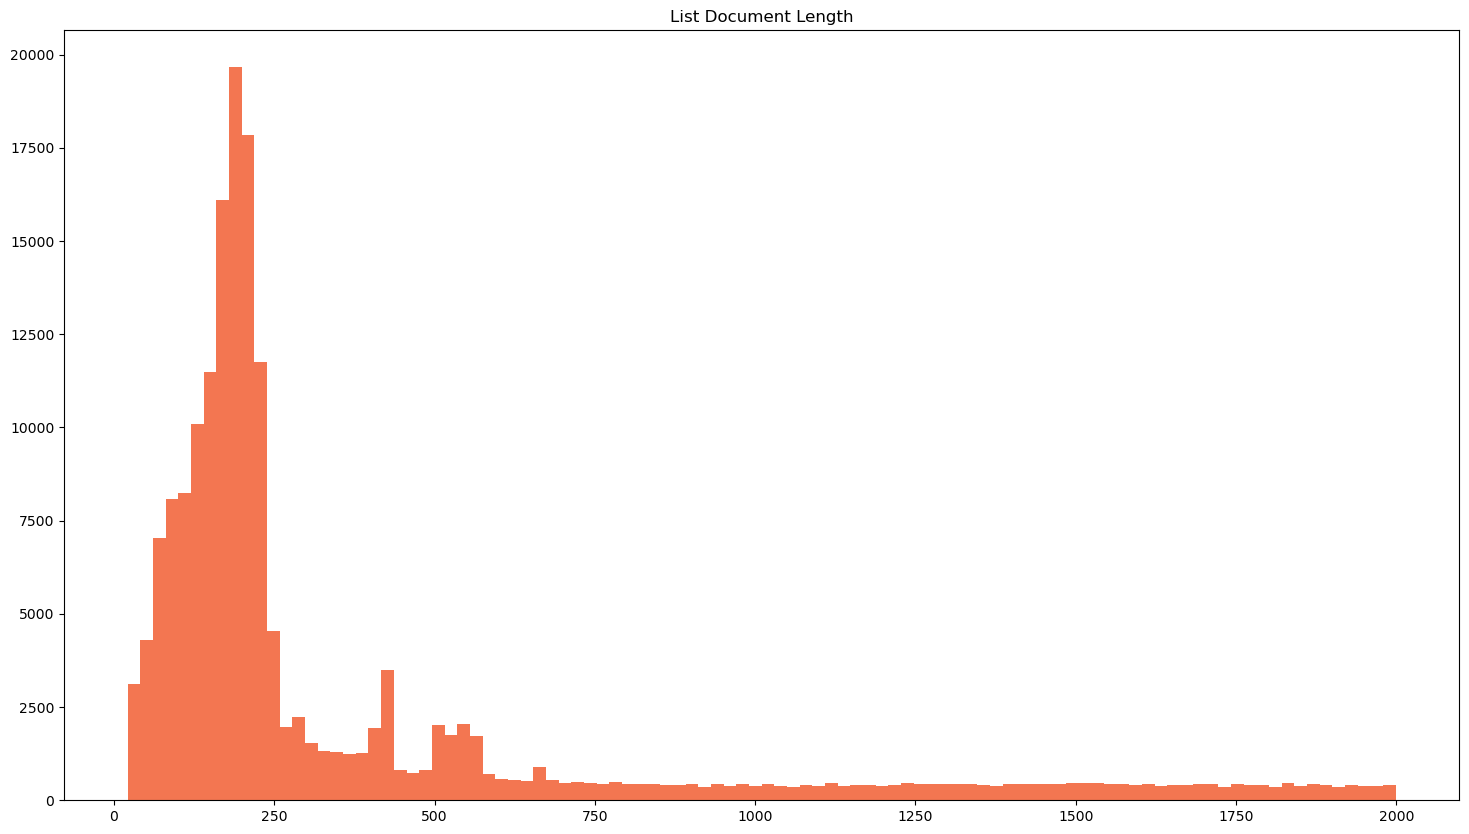

In [310]:
plt.figure(figsize=(18, 10))
plt.hist(list_length, bins=100, color=sns.color_palette("rocket")[4])
plt.title("List Document Length")
plt.savefig("output/list_document_length.png")
plt.show()

In [311]:
df = df.sample(frac=1, random_state=42)
X, y = df["message"], df["label"].map({"ai":1, "human":0}).values

In [312]:
df.head()

,message,label
92530,Bulbophyllum macrourum adalah spesies tumbuhan...,human
42367,Sejarah. Zaman prasejarah. Situs-situs arkeolo...,ai
54989,B-lagu: Singel-singel: Singel-singel: Singel-s...,ai
102443,Untuk semua jenis musik yang memakai genre mus...,ai
85971,"Sekolah, rumah, dan sebagainya. Pada tahun 196...",ai


In [313]:
df["label"].value_counts()

label
ai       99830
human    80122
Name: count, dtype: int64

In [314]:
from sklearn.model_selection import train_test_split

In [315]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify=y, random_state=SEED)

In [317]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")

X_train shape: (143961,)
y_train shape: (143961,)
X_val shape:   (35991,)
y_val shape:   (35991,)


### Vectorization

#### Doc2Vec

In [318]:
#Construct Tagged Doccument
train_tagged = construct_tagged_document(X_train, y_train)
val_tagged = construct_tagged_document(X_val, y_val)
data_tagged = train_tagged + val_tagged
pd.DataFrame(data_tagged).head()

,words,tags
0,"[pendidikan, fakultas, administrasi, sosial, d...","[1, 126904]"
1,"[beberapa, sumber, daya, manusia, termasuk, da...","[1, 43669]"
2,"[pertemuan, ini, tak, terlepas, dari, fakta, b...","[0, 61892]"
3,"[di, bayang, bayang, asmara, atau, bayang, bay...","[0, 78404]"
4,"[adalah, spesies, spons, yang, tergolong, dala...","[0, 176142]"


In [319]:
INPUT_DIM = 1000
EPOCHS = 20
MIN_COUNT = 0
RETRAIN = [True, False][1]

In [320]:
import multiprocessing

In [321]:
cores = multiprocessing.cpu_count()

In [323]:
d2v = None
file_path = "saved_models/doc2Vec.d2v"

In [325]:
from tqdm import tqdm
import os

In [326]:
if os.path.isfile(file_path) and RETRAIN == False:
    print("Read Model")
    d2v = Doc2Vec.load(file_path)
else:
    print("Train Model")
    d2v = Doc2Vec(
        dm=1,
        vector_size=INPUT_DIM,
        negative=1,
        hs=0,
        min_count=MIN_COUNT,
        workers=cores
    )

    d2v.build_vocab(data_tagged)

    for epoch in tqdm(range(EPOCHS), desc="Training Doc2Vec"):
        d2v.train(
            data_tagged,
            total_examples=d2v.corpus_count,
            epochs=1
        )
        d2v.alpha -= 0.002
        d2v.min_alpha = d2v.alpha

    d2v.save(file_path)


Train Model


Training Doc2Vec:  15%|█▌        | 3/20 [01:46<10:01, 35.41s/it]Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Training Doc2Vec: 100%|██████████| 20/20 [15:02<00:00, 45.14s/it]


In [327]:
vocab = len(d2v.dv)

In [328]:
vocab

179952

In [330]:
def d2v_vector(d2v, data_tagged, desc="Infer vectors"):
    labels = []
    features = []

    for doc in tqdm(data_tagged, desc=desc):
        labels.append(doc.tags[0])
        vec = d2v.infer_vector(doc.words, epochs=20)
        features.append(vec)

    features = np.array(features)
    return features, labels

In [331]:
X_train_vector, y_train_tag = d2v_vector(d2v, train_tagged, desc="Inferring Train Vectors")
X_train_reshaped, y_train_reshaped = transform_data(X_train_vector,  y_train_tag)
X_val_vector, y_val_tag = d2v_vector(d2v, val_tagged, desc="Inferring Validation Vectors")
X_val_reshaped, y_val_reshaped = transform_data(X_val_vector, y_val_tag)

Inferring Validation Vectors: 100%|██████████| 35991/35991 [00:57<00:00, 630.75it/s]


In [332]:
print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"y_train_reshaped shape: {y_train_reshaped.shape}")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"y_val_reshaped shape: {y_val_reshaped.shape}")

X_train_reshaped shape: (143961, 1000, 1)
y_train_reshaped shape: (143961, 1)
X_val_reshaped shape: (35991, 1000, 1)
y_val_reshaped shape: (35991, 1)


#### BertTokenizer

In [334]:
from transformers import BertTokenizer, BertForSequenceClassification as BertClassifier
from transformers import get_linear_schedule_with_warmup
import time

In [335]:
indobert = "indolem/indobert-base-uncased"
start_time = time.time()

In [336]:
tokenizer = BertTokenizer.from_pretrained(indobert, do_lower_case=True)

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [ ]:
X_train_encoded = encoded_data(tokenizer, X_train)
X_val_encoded = encoded_data(tokenizer, X_val)

X_train_ids = X_train_encoded["input_ids"]
X_train_mask = X_train_encoded["attention_mask"]
y_train_tensor = torch.tensor(y_train)

X_val_ids = X_val_encoded["input_ids"]
X_val_mask = X_val_encoded["attention_mask"]
y_val_tensor = torch.tensor(y_val)

In [340]:
print(f'X_train_ids shape: {X_train_ids.shape}')
print(f'X_train_mask shape: {X_train_mask.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'X_val_ids shape: {X_val_ids.shape}')
print(f'X_val_mask shape: {X_val_mask.shape}')
print(f'y_val_tensor shape: {y_val_tensor.shape}')

X_train_ids shape: torch.Size([143961, 896])
X_train_mask shape: torch.Size([143961, 896])
y_train_tensor shape: torch.Size([143961])
X_val_ids shape: torch.Size([35991, 684])
X_val_mask shape: torch.Size([35991, 684])
y_val_tensor shape: torch.Size([35991])


In [341]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [342]:
dataset_train = TensorDataset(X_train_ids, X_train_mask, y_train_tensor)
dataset_val = TensorDataset(X_val_ids, X_val_mask, y_val_tensor)

In [343]:
print(len(dataset_train))
print(len(dataset_val))

143961
35991


### Model Training

In [345]:
print("Use GPU") if tf.test.is_built_with_cuda() \
    and tf.config.list_physical_devices("GPU") else print("Use CPU")

Use CPU


In [390]:
experiments = []
unit = 50
d_rate = 0.2
a_rate = 1e-4
deep_epochs = 6
deep_size = 15
clean_memory()

In [391]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from torch.optim import AdamW
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

### BiLSTM

In [392]:
from keras.layers import Dense, LSTM, Dropout, Bidirectional

In [393]:
bilstm = Sequential(name="BI_LSTM")
bilstm.add(Bidirectional(LSTM(unit, return_sequences=True)))
bilstm.add(Dropout(d_rate))
bilstm.add(Bidirectional(LSTM(unit, return_sequences=True)))
bilstm.add(Dropout(d_rate))
bilstm.add(Bidirectional(LSTM(unit, return_sequences=True)))
bilstm.add(Dropout(d_rate))
bilstm.add(Bidirectional(LSTM(unit)))
bilstm.add(Dropout(d_rate))
bilstm.add(Dense(1, activation="sigmoid"))
bilstm.build(input_shape=X_train_reshaped.shape)
bilstm.compile(optimizer=Adam(learning_rate=a_rate), loss="binary_crossentropy", 
               metrics=["accuracy"])
bilstm.summary()

Model: "BI_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (143961, 1000, 100)    │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (143961, 1000, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (143961, 1000, 100)    │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (143961, 1000, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (143961, 1000, 100)    │        60,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (143961, 1000, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (143961, 100)          │        60,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (143961, 100)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (143961, 1)            │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,101 (789.46 KB)

 Trainable params: 202,101 (789.46 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = ModelCheckpoint("saved_models/bi_lstm.h5", monitor="val_accuracy", save_best_only=True, 
                             mode="max", verbose=1)
experiments.append(bilstm.fit(X_train_reshaped, y_train_reshaped,
                               validation_data=(X_val_reshaped, y_val_reshaped), 
                               epochs=deep_epochs, batch_size=deep_size, verbose=1,
                                callbacks=[checkpoint]))
#best_bilstm = tf.keras.saving.load_model("saved_models/bi_lstm.h5")

Epoch 1/6
9598/9598 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8131 - loss: 0.4091
Epoch 1: val_accuracy improved from -inf to 0.86874, saving model to saved_models/bi_lstm.h5


9598/9598 ━━━━━━━━━━━━━━━━━━━━ 28356s 3s/step - accuracy: 0.8131 - loss: 0.4091 - val_accuracy: 0.8687 - val_loss: 0.3021
Epoch 2/6
9598/9598 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8802 - loss: 0.2821
Epoch 2: val_accuracy improved from 0.86874 to 0.90353, saving model to saved_models/bi_lstm.h5


9598/9598 ━━━━━━━━━━━━━━━━━━━━ 54837s 6s/step - accuracy: 0.8802 - loss: 0.2821 - val_accuracy: 0.9035 - val_loss: 0.2380
Epoch 3/6
9598/9598 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9067 - loss: 0.2273
Epoch 3: val_accuracy improved from 0.90353 to 0.92109, saving model to saved_models/bi_lstm.h5


9598/9598 ━━━━━━━━━━━━━━━━━━━━ 37661s 4s/step - accuracy: 0.9067 - loss: 0.2273 - val_accuracy: 0.9211 - val_loss: 0.2000
Epoch 4/6
9598/9598 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9197 - loss: 0.2002
Epoch 4: val_accuracy improved from 0.92109 to 0.92643, saving model to saved_models/bi_lstm.h5


9598/9598 ━━━━━━━━━━━━━━━━━━━━ 21011s 2s/step - accuracy: 0.9197 - loss: 0.2002 - val_accuracy: 0.9264 - val_loss: 0.1857
Epoch 5/6
9598/9598 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9262 - loss: 0.1863
Epoch 5: val_accuracy improved from 0.92643 to 0.93101, saving model to saved_models/bi_lstm.h5


9598/9598 ━━━━━━━━━━━━━━━━━━━━ 29601s 3s/step - accuracy: 0.9262 - loss: 0.1863 - val_accuracy: 0.9310 - val_loss: 0.1760
Epoch 6/6
9598/9598 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9284 - loss: 0.1781
Epoch 6: val_accuracy improved from 0.93101 to 0.93240, saving model to saved_models/bi_lstm.h5


9598/9598 ━━━━━━━━━━━━━━━━━━━━ 39779s 4s/step - accuracy: 0.9284 - loss: 0.1781 - val_accuracy: 0.9324 - val_loss: 0.1724


AttributeError: module 'keras._tf_keras.keras' has no attribute 'saving'

In [399]:
best_bilstm = tf.keras.models.load_model("saved_models/bi_lstm.h5")

In [400]:
from sklearn.metrics import classification_report

y_bilstm_pred = best_bilstm.predict(X_val_reshaped)
y_bilstm_pred = np.round(y_bilstm_pred).astype(int).flatten()
y_val_reshaped = y_val_reshaped.astype(int).flatten()

report = classification_report(
    y_val_reshaped,
    y_bilstm_pred
)


print(report)

with open("output/bilstm_classification_report.txt", "w") as f:
    f.write(report)

np.save("output/y_val.npy", y_val_reshaped)
np.save("output/y_bilstm_pred.npy", y_bilstm_pred)

report_dict = classification_report(
    y_val_reshaped,
    y_bilstm_pred,
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv("output/bilstm_classification_report.csv")


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1764s 2s/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     16025
           1       0.93      0.95      0.94     19966

    accuracy                           0.93     35991
   macro avg       0.93      0.93      0.93     35991
weighted avg       0.93      0.93      0.93     35991



In [405]:
experiments[0]

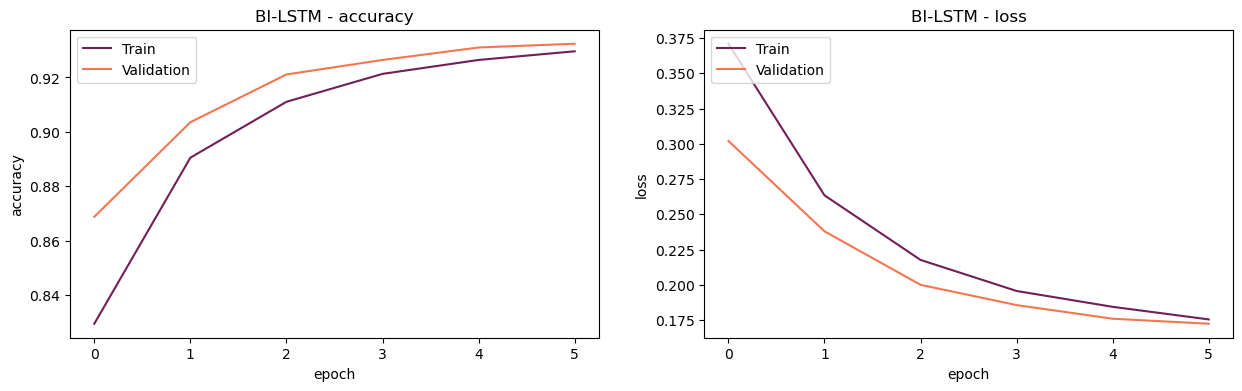

In [406]:
plt.figure(figsize=(15,4))
metrics_plot = ["accuracy", "loss"]

for i, metric in enumerate(metrics_plot):
    plt.subplot(1, 2, i + 1)
    experiment = experiments[0]
    plt.plot(experiment.history[metric], color=sns.color_palette("rocket")[1])
    plt.plot(experiment.history[f"val_{metric}"], color=sns.color_palette("rocket")[4])
    plt.title(f"BI-LSTM - {metric}")
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

plt.savefig("output/bilstm_accuracy_loss.png", bbox_inches="tight", dpi=300)
plt.show()